# Previous alignment experiments

Checking alignment and loss for autoencoding a single training example across a variety of network architectures.

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import train_utils as train
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in l

In [2]:
def gen_plots(all_align, all_losses, all_svals):
    for i in range(len(all_align)):
        fig, axes = plt.subplots(nrows=1, ncols=2)
        fig.suptitle("depth = " + str(i+1), fontsize="x-large")
        axes[0].set_title("alignment")
        axes[0].plot(all_align[i])
        axes[1].set_title("loss")
        axes[1].plot(all_losses[i])
        axes[1].set_yscale("log")
        plt.show()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title("singular vals")
    axes[0].plot(range(1, len(all_svals)+1), all_svals)
    axes[1].set_title("stable rank")
    axes[1].plot(range(1, len(all_svals)+1), [train.stable_rank(i) for i in all_svals])
    plt.show()

# Fully Connected Network

In [3]:
import random
class FCNLayer(train.BaseLayer):
    
    def __init__(self, n, init_val, init_vec=None):
        super(FCNLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(n, n)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))

class DeepFCN(train.DeepNet):
    
    def __init__(self, n, depth, init_vec=None):
        super(DeepFCN, self).__init__(n, depth)
        self.init_val = 0.1
        
        if init_vec is None:
            self.layers = nn.ModuleList([FCNLayer(n, self.init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([FCNLayer(n, 0.0, init_vec=random.random()*init_vec) for i in range(depth)])

depth = 3
BAD


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


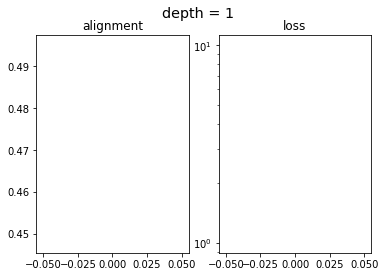

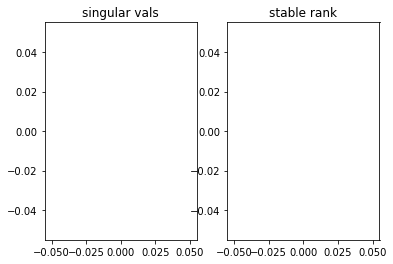

In [17]:
n = 4
all_losses = []
all_align = []
all_svals = []
for depth in range(3, 4):
    print("depth = " + str(depth))
    # initialize randomly
    net = DeepFCN(n, depth)

    # random x
    
    x = torch.randn(1, n)
    
    losses, align, svals, new_align = train.train(net, x, 1e-6)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

In [18]:
# final magnitude of alignment is ~ 0.996
align[0]

0.47138527035713196

depth = 1
0.002153713721781969
depth = 2
0.03706364333629608
depth = 3
0.0012066216440871358
depth = 4
0.5324463248252869
depth = 5
1.1160435676574707
depth = 6
0.24463528394699097


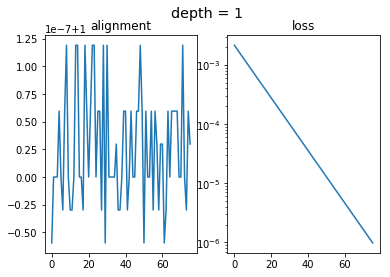

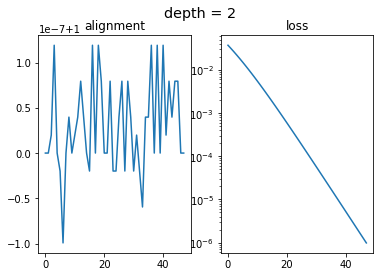

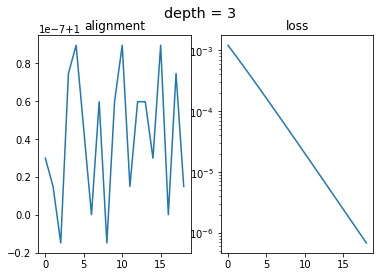

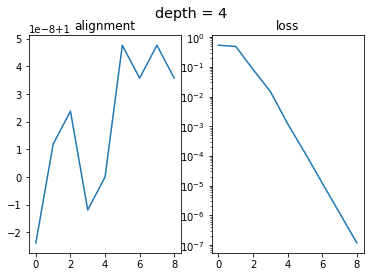

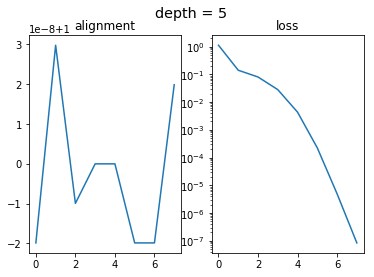

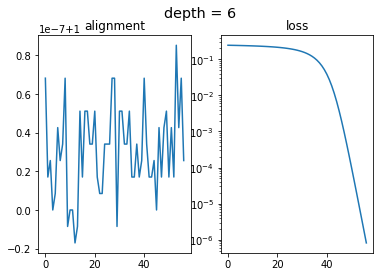

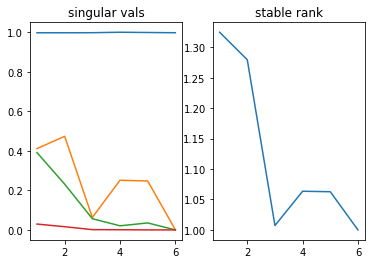

In [8]:
# initialize aligned
n = 4
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    
    # initialize aligned
    init = 1.0*np.random.normal(size = (n, n))
    init = 0.5*init + 0.5*np.transpose(init)
#     init = np.ones((n, n))

    net = DeepFCN(n, depth, init_vec = init)

    # choose aligned x
    layer = net.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(net, x, 1e-6)

    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

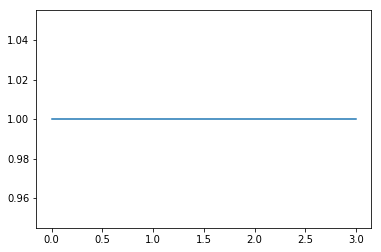

In [23]:
plt.plot(new_align)

# Toeplitz

In [10]:
class ToeplitzLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        
        super(ToeplitzLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(2*n -1)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return torch.stack([F.linear(self.weight.narrow(0, self.n-1-i,self.n), input) for i in range(self.n)], dim=1)
    
    def weight_matrix(self):
        return torch.stack([self.weight.narrow(0, self.n-1-i,self.n) for i in range(self.n)])
                            
class DeepToeplitz(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepToeplitz, self).__init__(n, depth)

        init_vals = {2: 1e-9, 3: 1e-2, 4: 1e-1, 5: 1e-1, 6: 1e-1}
        if init_vec is None:
            self.layers = nn.ModuleList([ToeplitzLayer(n, init_vals[self.depth]) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([ToeplitzLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

depth = 1
0.09827796369791031
depth = 2
0.1627504527568817
depth = 3
0.009320548735558987
depth = 4
0.19548358023166656
depth = 5
0.16391822695732117
depth = 6
0.11529506742954254


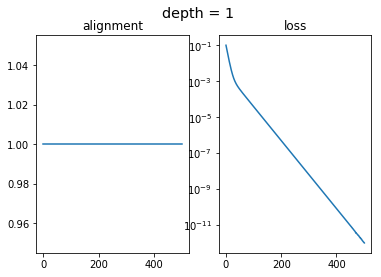

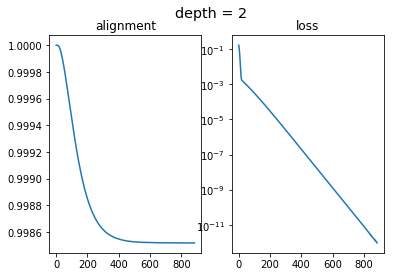

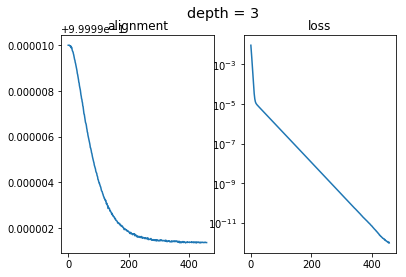

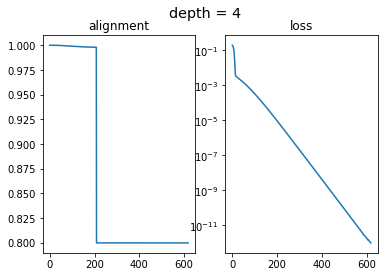

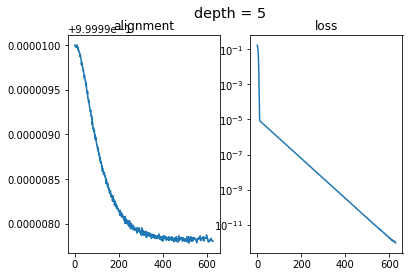

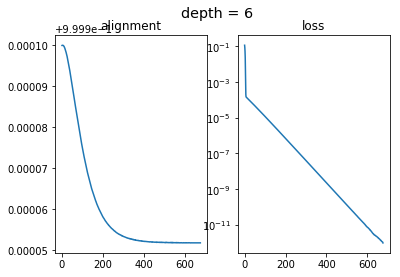

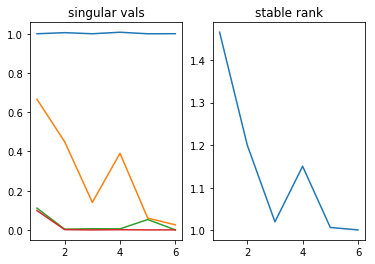

In [13]:
n = 4

# GOAL: Initialize each toeplitz layer to be the SAME, and see if alignment persists throughout training
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    # initialize symmetric toeplitz matrix
    rand = 0.2*np.random.normal(size=n)
    init_vec = np.zeros(2*n - 1)

    for i in range(n):
        init_vec[i] = rand[i]
        init_vec[2*n - 2 - i] = rand[i]

    toep = DeepToeplitz(n, depth, init_vec = init_vec)

    # initialize data to get data alignment
    layer = toep.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(toep, x, 1e-12)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

# Symmetric Toeplitz

In [14]:
# Now we FORCE each layer to be symmetric and toeplitz
class SymToeplitzLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        
        super(SymToeplitzLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(n)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return torch.stack([F.linear(torch.cat([torch.flip(self.weight.narrow(0, 1, i), dims=[0]), 
                                                self.weight.narrow(0, 0,self.n-i)]), input) 
                            for i in range(self.n)], dim=1)
    
    def weight_matrix(self):
        return torch.stack([torch.cat([torch.flip(self.weight.narrow(0, 1, i), dims=[0]),
                                       self.weight.narrow(0, 0,self.n-i)]) 
                            for i in range(self.n)], dim = 1)
                            
class DeepSymToeplitz(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepSymToeplitz, self).__init__(n, depth)

        init_vals = {2: 1e-9, 3: 1e-2, 4: 1e-1, 5: 1e-1, 6: 1e-1}
        if init_vec is None:
            self.layers = nn.ModuleList([SymToeplitzLayer(n, init_vals[self.depth]) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([SymToeplitzLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

depth = 1
0.8241256475448608
depth = 2
0.13383932411670685
depth = 3
0.0640629231929779
depth = 4
0.24498125910758972
depth = 5
0.25099363923072815
0.25000935792922974
0.250002384185791
0.2500002980232239
0.24999907612800598
0.24999812245368958
0.24999713897705078
0.24999597668647766
0.24999433755874634
0.249991774559021
0.2499869465827942
0.2499750554561615
0.2499231994152069
0.017887180671095848
depth = 6
0.2345353066921234


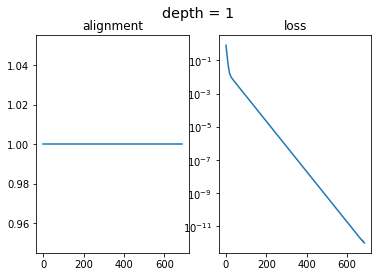

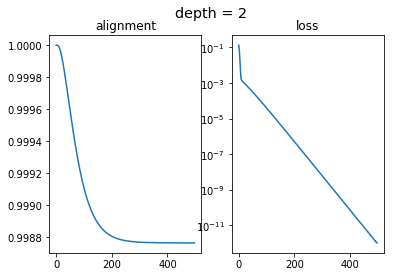

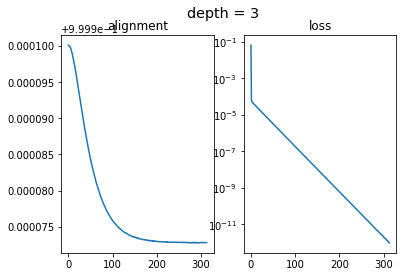

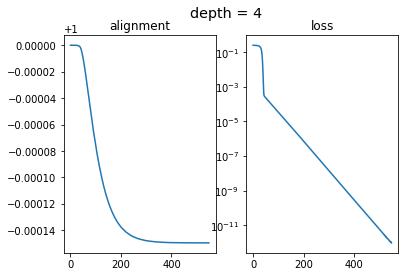

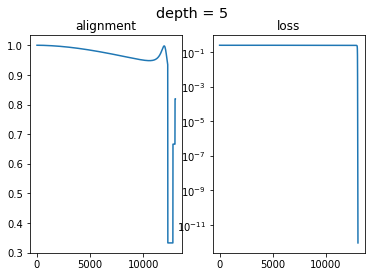

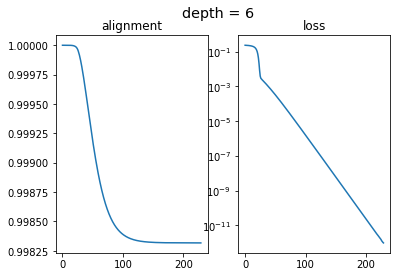

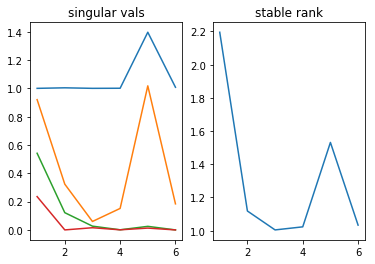

In [16]:
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    # initialize symmetric toeplitz matrix
    init_vec = 0.2*np.random.normal(size=n)

    toep = DeepSymToeplitz(n, depth, init_vec = init_vec)

    # initialize data to get data alignment
    layer = toep.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(toep, x, 1e-12)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

# Doubly Symmetric Toeplitz

# Tridiagonal

In [17]:
# Now we FORCE each layer to be symmetric and toeplitz
class TridiagLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        
        super(TridiagLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(3)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return F.linear(input, self.weight_matrix())
    
    def weight_matrix(self):
        rows = []
        rows.append(torch.cat([self.weight.narrow(0, 1, 2), torch.zeros(self.n - 2)]))
        for i in range(1, n-1):
            rows.append(torch.cat([torch.zeros(i-1), self.weight, torch.zeros(self.n - i - 2)]))
        rows.append(torch.cat([torch.zeros(n-2), self.weight.narrow(0, 0, 2)]))
        return torch.stack(rows, dim = 1)
                            
class DeepTridiag(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepTridiag, self).__init__(n, depth)

        init_val = 0.1
        if init_vec is None:
            self.layers = nn.ModuleList([TridiagLayer(n, init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([TridiagLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

depth = 1
0.09342991560697556
depth = 2
0.2394484281539917
depth = 3
0.2409563958644867
depth = 4
0.24067217111587524
depth = 5
0.24757832288742065
depth = 6
0.24981307983398438


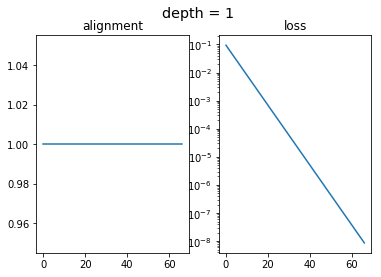

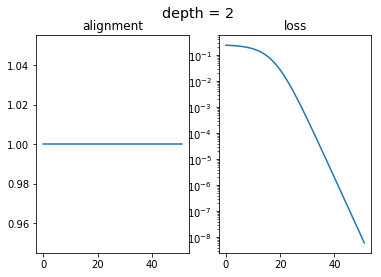

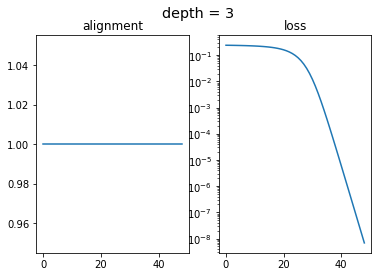

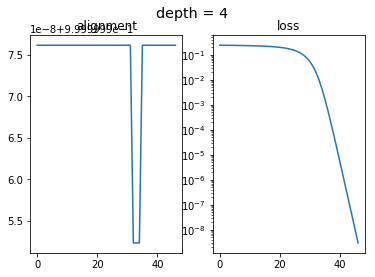

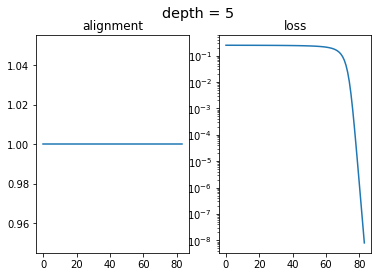

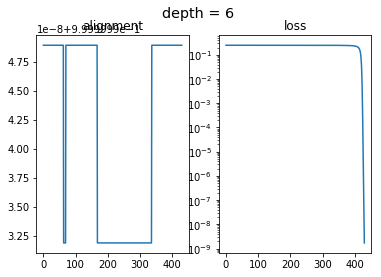

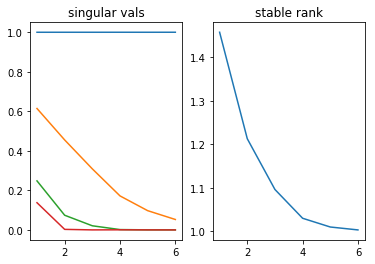

In [20]:
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    # initialize symmetric tridiagonal matrix
    init_vec = 0.1*np.random.normal(size=3)
    init_vec[2] = init_vec[0]
    tri = DeepTridiag(n, depth, init_vec = init_vec)

    # initialize data to get data alignment
    layer = tri.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(tri, x, 1e-8)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

In [62]:
tri.weight_matrix()

tensor([[0.9998, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9998, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9998, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9998]], grad_fn=<MmBackward>)

In [124]:
init_vec = 0.1*np.random.normal(size=3)
init_vec[2] = init_vec[0]
print(init_vec)
tri = DeepTridiag(n, 2, init_vec = init_vec)
Q = np.linalg.svd(tri.layers[0].weight_matrix().detach().numpy())[0]
x = torch.tensor(np.linalg.svd(tri.layers[0].weight_matrix().detach().numpy())[2][0].reshape(1, n))
print(Q)
print(x)

[ 0.05224893  0.01956117  0.05224893]
[[-0.37174803  0.37174803  0.60150093  0.60150093]
 [-0.60150093 -0.60150093  0.37174803 -0.37174803]
 [-0.60150093  0.60150093 -0.37174803 -0.37174803]
 [-0.37174803 -0.37174803 -0.60150093  0.60150093]]
tensor([[-0.3717, -0.6015, -0.6015, -0.3717]])


In [111]:
optimizer = optim.SGD(tri.parameters(), lr = 0.1)
criterion = nn.MSELoss()
print(train.alignment(tri, x))
optimizer.zero_grad()
y = tri(x)
loss = criterion(x, y)
loss.backward()
optimizer.step()
print(train.alignment(tri, x))
print(tri.layers[0].weight_matrix())
print(tri.layers[1].weight_matrix())

0.999999960264
0.999999960264
tensor([[0.0811, 0.0444, 0.0000, 0.0000],
        [0.0444, 0.0811, 0.0444, 0.0000],
        [0.0000, 0.0444, 0.0811, 0.0444],
        [0.0000, 0.0000, 0.0444, 0.0811]], grad_fn=<StackBackward>)
tensor([[0.0811, 0.0444, 0.0000, 0.0000],
        [0.0444, 0.0811, 0.0444, 0.0000],
        [0.0000, 0.0444, 0.0811, 0.0444],
        [0.0000, 0.0000, 0.0444, 0.0811]], grad_fn=<StackBackward>)


In [104]:
np.linalg.svd(tri.weight_matrix().detach().numpy())[0]

array([[-0.37174803,  0.60150093, -0.60150093, -0.37174803],
       [-0.60150093,  0.37174803,  0.37174803,  0.60150093],
       [-0.60150093, -0.37174803,  0.37174803, -0.60150093],
       [-0.37174803, -0.60150093, -0.60150093,  0.37174803]], dtype=float32)

In [105]:
Q

array([[-0.37174803,  0.60150093, -0.60150093, -0.37174803],
       [-0.60150093,  0.37174803,  0.37174803,  0.60150093],
       [-0.60150093, -0.37174803,  0.37174803, -0.60150093],
       [-0.37174803, -0.60150093, -0.60150093,  0.37174803]], dtype=float32)

# Convolutional

In [10]:
# 2x2 is just the same as toeplitz
# encode a 3x3 matrix
class ConvLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        # n has to equal 9 for now
        super(ConvLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(9)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        
    def forward(self, input):
        return F.linear(input, self.weight_matrix())
    
    def weight_matrix(self):
        rows = [
            torch.cat([self.weight.narrow(0, 4, 2), torch.zeros(1), self.weight.narrow(0, 7, 2), torch.zeros(4)]),
            torch.cat([self.weight.narrow(0, 3, 6), torch.zeros(3)]),
            torch.cat([torch.zeros(1), self.weight.narrow(0, 3, 2), torch.zeros(1), self.weight.narrow(0, 6, 2), torch.zeros(3)]),
            torch.cat([self.weight.narrow(0, 1, 2), torch.zeros(1), self.weight.narrow(0, 4, 2), torch.zeros(1), self.weight.narrow(0, 7, 2), torch.zeros(1)]),
            self.weight,
            torch.cat([torch.zeros(1), self.weight.narrow(0, 0, 2), torch.zeros(1), self.weight.narrow(0, 3, 2), torch.zeros(1), self.weight.narrow(0, 6, 2)]),
            torch.cat([torch.zeros(3), self.weight.narrow(0, 1, 2), torch.zeros(1), self.weight.narrow(0, 4, 2), torch.zeros(1)]),
            torch.cat([torch.zeros(3), self.weight.narrow(0, 0, 6)]),
            torch.cat([torch.zeros(4), self.weight.narrow(0, 0, 2), torch.zeros(1), self.weight.narrow(0, 3, 2)])
        ]
        return torch.stack(rows, dim = 1)
                            
class DeepConv(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):
        
        super(DeepConv, self).__init__(n, depth)

        init_val = 0.1
        if init_vec is None:
            self.layers = nn.ModuleList([ConvLayer(n, init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([ConvLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

depth = 1
0.41692835092544556
depth = 2
0.013319578021764755
depth = 3
0.0433494858443737
depth = 4
0.0795523002743721
2.352083356527146e-05
depth = 5
0.18913763761520386
0.11116880923509598
0.1111341342329979
0.111124187707901
0.11111977696418762
0.11111744493246078
0.11111605167388916
0.11111516505479813
0.11111453175544739
0.11111404001712799
0.11111365258693695
0.11111332476139069
0.11111301928758621
0.11111274361610413
0.11111243814229965
0.11111211776733398
0.11111176013946533
0.11111129820346832
0.11111067235469818
0.11110969632863998
0.11110791563987732
0.11110364645719528
0.11108482629060745
0.001114267623052001
5.556347605306655e-05
2.8262318664928898e-05
1.49344250530703e-05
depth = 6
0.10098762810230255


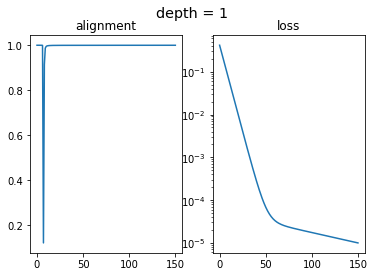

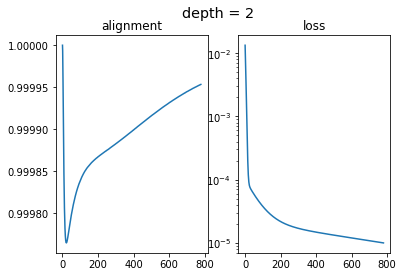

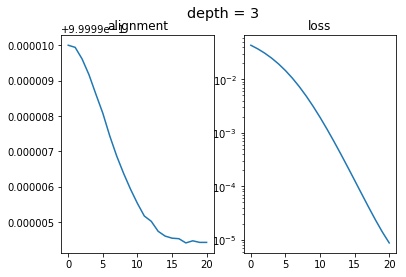

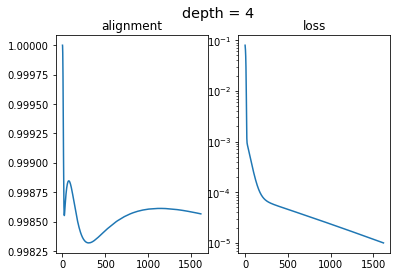

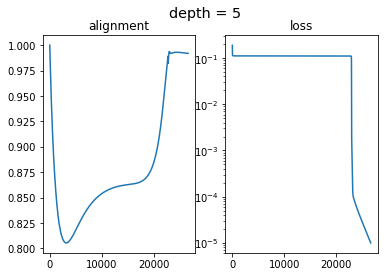

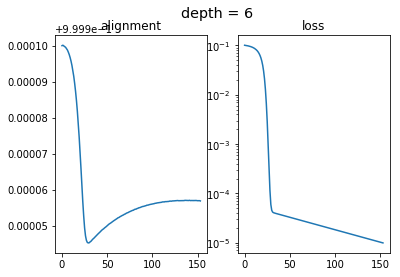

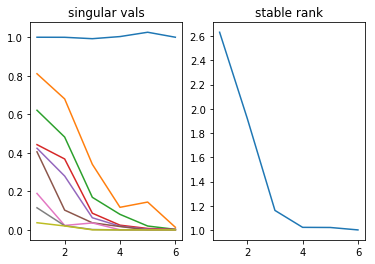

In [19]:
n = 9
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    # initialize symmetric convolutional matrix
    init_vec = 0.2*np.random.normal(size=9)
    init_vec[8] = init_vec[0]
    init_vec[7] = init_vec[1]
    init_vec[6] = init_vec[2]
    init_vec[5] = init_vec[3]
    conv = DeepConv(n, depth, init_vec = init_vec)

    # initialize data to get data alignment
    layer = conv.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(conv, x, 1e-5)# low b/c i got impatient
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

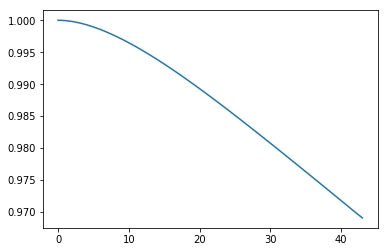

In [13]:
plt.plot(new_align)

In [18]:
x_unit = x / np.linalg.norm(x)
x_unit = x_unit.reshape(-1)
u_vals = []
vh_vals = []
for layer in conv.layers:
    u, s, vh = np.linalg.svd(layer.weight_matrix().detach().numpy())
    u_vals.append(u)
    vh_vals.append(vh)
    print(s)
w0 = conv.layers[0].weight_matrix().detach().numpy()
res = np.matmul(np.matmul(w0.transpose() , w0), x_unit.reshape(-1, 1))
total_alignment = abs((np.dot(res.reshape(-1), x_unit.reshape(-1))/np.linalg.norm(res)).item())
wn = conv.layers[len(conv.layers) - 1].weight_matrix().detach().numpy()
res = np.matmul(np.matmul(wn , wn), x_unit.reshape(-1, 1))
total_alignment += abs((np.dot(res.reshape(-1), x_unit.reshape(-1))/np.linalg.norm(res)).item())

[ 0.46375433  0.46366954  0.39332736  0.17455471  0.16506988  0.15845908
  0.14972275  0.13947687  0.06530716]
[ 0.52573597  0.4820793   0.37001637  0.26496562  0.21380433  0.17891105
  0.0468926   0.04675762  0.03820263]
[ 0.46157458  0.46137992  0.3871063   0.17161432  0.17048581  0.15707451
  0.15361439  0.13381959  0.06991746]


In [19]:
print(total_alignment)
total_alignment += sum([abs(np.dot(u_vals[i].transpose()[0], vh_vals[i+1][0])) 
    for i in range(len(conv.layers) - 1)])
print(total_alignment)

1.6912980675697327
2.57465316146


In [21]:
print(train.alignment_new(conv, x))

0.9136200100183487


In [20]:
for i in range(9):
    print(np.dot(u_vals[0].transpose()[0], vh_vals[1][i]))
    
print(u_vals[0])
print(vh_vals[1][0])

7.24103e-08
-0.993823
0.0
0.110647
-2.98023e-08
0.00846745
-2.23517e-08
-1.49012e-08
0.000942733
[[ -2.89025247e-01   2.07784623e-01  -3.69201839e-01   1.27655968e-01
   -3.36553067e-01  -4.07219321e-01  -2.55580544e-01   5.78659773e-01
   -2.03518689e-01]
 [  4.99440402e-01   3.20792943e-02   4.98805344e-01   2.36494672e-02
   -1.98209345e-01  -4.35869694e-02  -4.99440432e-01   2.36492306e-02
   -4.57140386e-01]
 [ -2.55580157e-01  -2.40908369e-01  -3.37363988e-01  -5.78660011e-01
    5.73240556e-02   3.57445270e-01  -2.89024949e-01  -1.27655417e-01
   -4.43954498e-01]
 [  3.18908215e-01   3.85057330e-01  -1.79673191e-02  -3.85093689e-01
   -3.63410562e-01   4.52204764e-01   3.18908602e-01   3.85094017e-01
    1.21868551e-01]
 [  2.96203275e-08  -7.06385851e-01   3.86253893e-02   9.61650812e-07
   -6.51294470e-01   5.66593558e-03  -4.15277341e-08  -2.99842668e-07
    2.74427593e-01]
 [ -3.18908274e-01   3.85057330e-01  -1.79672688e-02   3.85094672e-01
   -3.63409102e-01   4.52205330e-

In [5]:
# randomly initialized convolutional matrix
n = 9
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    
    # randomly initialize conv net
    conv = DeepConv(n, depth)

    # random data
    x = torch.randn(1, n)
    
    losses, align, svals = train.train(conv, x, 1e-6)
    
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

depth = 1
BAD


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


IndexError: list index out of range

In [20]:
conv = DeepConv(9, 2, init_vec = init_vec)

In [23]:
conv.layers[0].weight_matrix()

tensor([[ 0.0275, -0.0578,  0.0000,  0.0224, -0.0878,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.0578,  0.0275, -0.0578, -0.1196,  0.0224, -0.0878,  0.0000,  0.0000,
          0.0000],
        [ 0.0000, -0.0578,  0.0275,  0.0000, -0.1196,  0.0224,  0.0000,  0.0000,
          0.0000],
        [ 0.0224, -0.1196,  0.0000,  0.0275, -0.0578,  0.0000,  0.0224, -0.0878,
          0.0000],
        [-0.0878,  0.0224, -0.1196, -0.0578,  0.0275, -0.0578, -0.1196,  0.0224,
         -0.0878],
        [ 0.0000, -0.0878,  0.0224,  0.0000, -0.0578,  0.0275,  0.0000, -0.1196,
          0.0224],
        [ 0.0000,  0.0000,  0.0000,  0.0224, -0.1196,  0.0000,  0.0275, -0.0578,
          0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0878,  0.0224, -0.1196, -0.0578,  0.0275,
         -0.0578],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0878,  0.0224,  0.0000, -0.0578,
          0.0275]], grad_fn=<StackBackward>)

# Missing entry

In [27]:
class ZeroEntryLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None):
        
        super(ZeroEntryLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(n, n)
            self.weight = nn.Parameter(torch.tensor(self.init))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
        # zero_entry
        zero_entry = (0, 1)
        self.mask = torch.autograd.Variable(torch.tensor([[1. for i in range(self.n)] for j in range(self.n)]), requires_grad = False)
        self.mask[zero_entry[0]][zero_entry[1]] = 0.0
        self.weight.data = self.weight.data*self.mask.data

        
    def forward(self, input):
        return F.linear(input, self.weight*self.mask)
    
    def weight_matrix(self):
        return self.weight*self.mask
                            
class DeepZeroEntry(train.DeepNet):
    def __init__(self, n, depth, init_vec=None):

        super(DeepZeroEntry, self).__init__(n, depth)

        self.init_val = 0.1
        if init_vec is None:
            self.layers = nn.ModuleList([ZeroEntryLayer(n, self.init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([ZeroEntryLayer(n, 0.0, init_vec=init_vec) for i in range(depth)])

depth = 1
1.0301874876022339
depth = 2
0.5342249870300293


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


depth = 3
0.40781670808792114
depth = 4
1.8101290464401245
depth = 5
0.9525701403617859
depth = 6
0.9313262104988098
0.9312494397163391


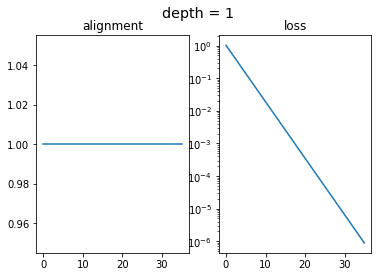

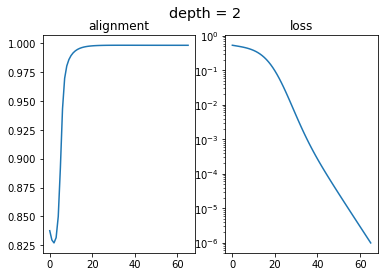

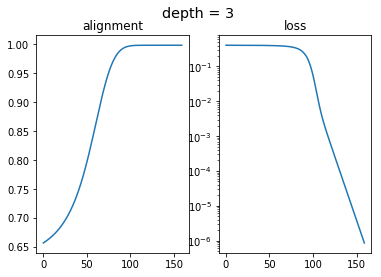

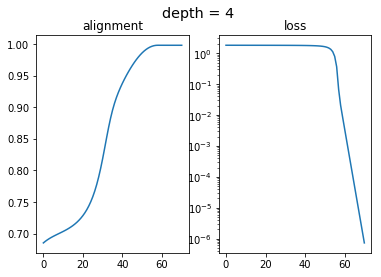

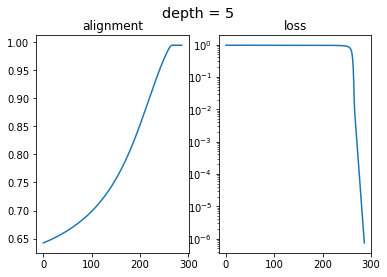

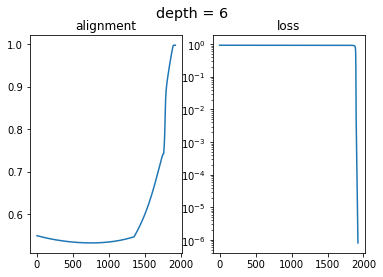

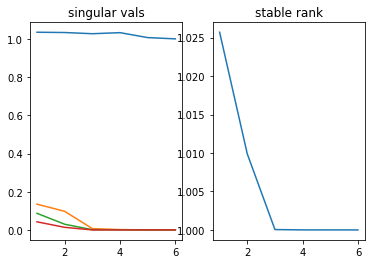

In [26]:
n = 4
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    # initialize randomly
    net = DeepZeroEntry(n, depth)

    # random x
    
    x = torch.randn(1, n)
    
    losses, align, svals = train.train(net, x, 1e-6)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

In [27]:
# magnitude of alignment = 0.997
all_align[5][-1]

0.99737199715205604

depth = 1
0.3570624589920044
depth = 2
0.24124646186828613
depth = 3
0.25441694259643555
0.24591824412345886
depth = 4
0.24793928861618042
depth = 5
0.24996289610862732
0.24988915026187897
0.24098099768161774
depth = 6
0.24996384978294373
0.24993157386779785
0.2497878074645996
2.2749621564344125e-07


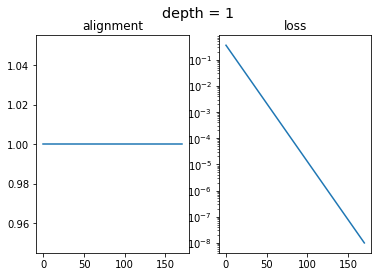

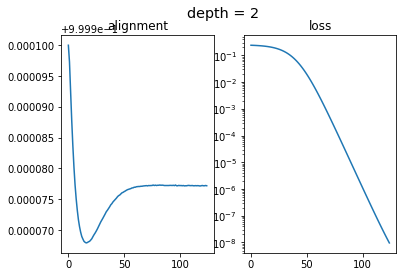

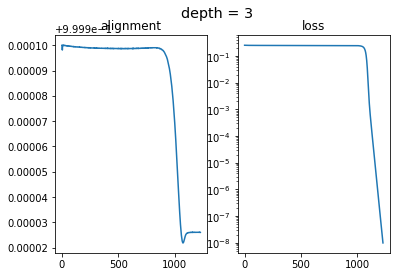

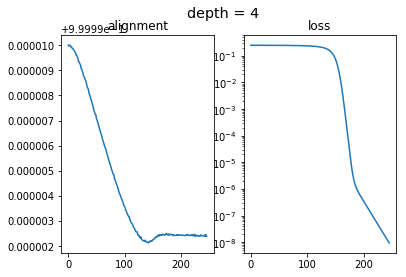

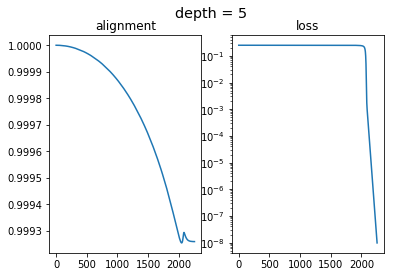

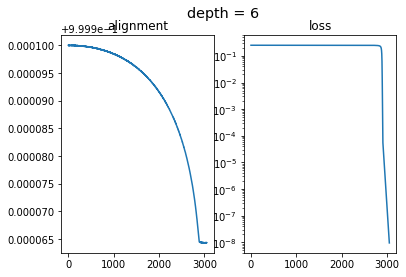

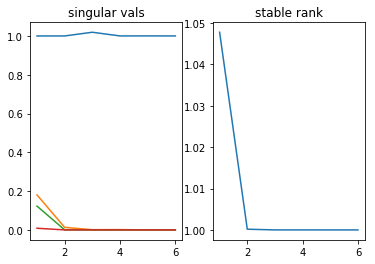

In [28]:
# initialize aligned
n = 4
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    
    # initialize aligned
    init = 0.1*np.random.normal(size = (n, n))
    init = 0.5*init + 0.5*np.transpose(init)
    init[0][1] = 0
    init[1][0] = 0
    net = DeepZeroEntry(n, depth, init_vec = init)

    # choose aligned x
    layer = net.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(net, x, 1e-8)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

In [30]:
all_align[5][-1]

0.99980844770159039

In [31]:
depth = 2
init = 0.1*np.random.normal(size = (n, n))
init = 0.5*init + 0.5*np.transpose(init)
init[0][1] = 0
init[1][0] = 0
net = DeepZeroEntry(n, depth, init_vec = init)
net.layers[1].weight_matrix()

tensor([[ 0.2379,  0.0000, -0.0443, -0.0018],
        [ 0.0000,  0.0146, -0.0749,  0.0779],
        [-0.0443, -0.0749,  0.0620, -0.0408],
        [-0.0018,  0.0779, -0.0408,  0.1907]], grad_fn=<MulBackward0>)

# Zero Trace

In [32]:
# Only random initialization works
class ZeroTraceLayer(train.BaseLayer):
    def __init__(self, n, init_val, init_vec=None, diag_vec = None):
        
        super(ZeroTraceLayer, self).__init__(n, init_val)
        if init_vec is None:
            self.init = self.init_val * torch.randn(n, n)
            self.weight = nn.Parameter(torch.tensor(self.init))
            self.diag = nn.Parameter(torch.tensor(self.init_val * torch.randn(n-1)))
        else:
            self.weight = nn.Parameter(torch.tensor(init_vec, dtype=torch.float32))
            self.diag = nn.Parameter(torch.tensor(diag_vec, dtype=torch.float32))
        
        
        self.basis = [
            torch.autograd.Variable(torch.tensor(np.diag([1., -1., 0., 0.]), dtype=torch.float32), requires_grad = False),
            torch.autograd.Variable(torch.tensor(np.diag([0., 0., 1., -1.]), dtype=torch.float32), requires_grad = False),
            torch.autograd.Variable(torch.tensor(np.diag([1., 1., -1., -1.]), dtype=torch.float32), requires_grad = False),
        ]

        
        self.mask = torch.autograd.Variable(torch.tensor([[(1. if i != j else 0.) for i in range(self.n)] for j in range(self.n)]), requires_grad = False)
#         self.weight.data = self.weight.data*self.mask.data

        
    def forward(self, input):
        return F.linear(input, self.weight_matrix())
    
    def weight_matrix(self):
        matrix = self.weight*self.mask
        for i in range(self.n - 1):
            matrix += self.diag[i]*self.basis[i]
        return matrix
                            
class DeepZeroTrace(train.DeepNet):
    def __init__(self, n, depth, init_vec=None, diag_vec=None):

        super(DeepZeroTrace, self).__init__(n, depth)

        self.init_val = 0.1
        if init_vec is None:
            self.layers = nn.ModuleList([ZeroTraceLayer(n, self.init_val) for i in range(depth)])
        else:
            self.layers = nn.ModuleList([ZeroTraceLayer(n, 0.0, init_vec=init_vec, diag_vec=diag_vec) for i in range(depth)])

In [33]:
net = ZeroTraceLayer(4, 0.1)
net.weight_matrix()
np.trace(net.weight_matrix().detach().numpy())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


0.0

depth = 1
0.37199801206588745
depth = 2
0.9460616111755371
depth = 3
0.3122408390045166


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


depth = 4
0.8878891468048096
depth = 5
0.6974431872367859
depth = 6
1.3062632083892822
0.02331176958978176
0.0017548920586705208
0.0001501628285041079
1.3317104276211467e-05
1.1941792763536796e-06


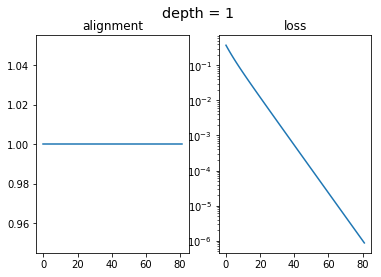

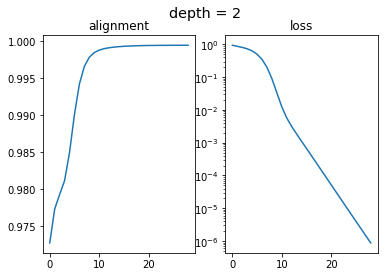

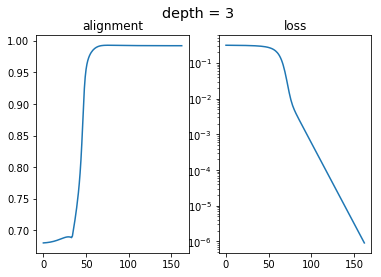

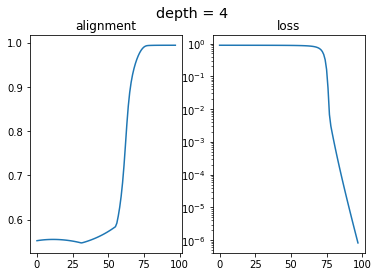

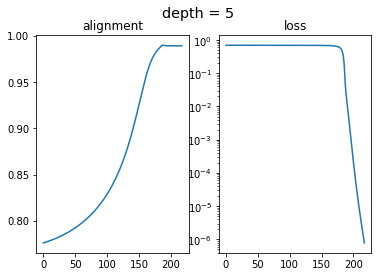

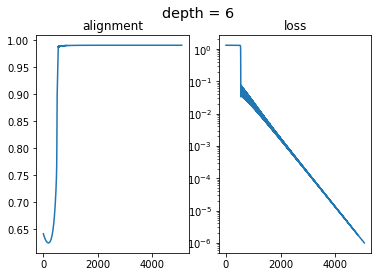

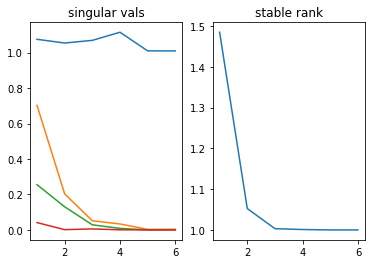

In [34]:
n = 4
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    # initialize randomly
    net = DeepZeroTrace(n, depth)

    # random x
    
    x = torch.randn(1, n)
    
    losses, align, svals = train.train(net, x, 1e-6)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

In [35]:
all_align[5][-1]

0.99105904783521381

depth = 1
0.3555803894996643
depth = 2
0.1942305862903595
depth = 3
0.18795126676559448
depth = 4
0.2490740418434143
depth = 5
0.250223308801651
0.25005245208740234
0.25002455711364746
0.25001445412635803
0.25000882148742676
0.25000321865081787
0.24999132752418518
0.24994640052318573
0.24876882135868073
depth = 6
0.24873143434524536


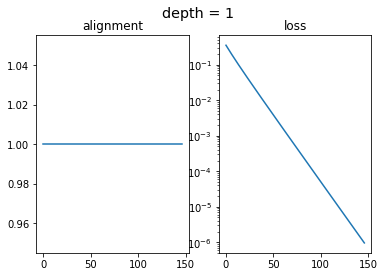

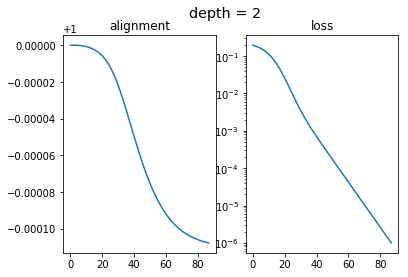

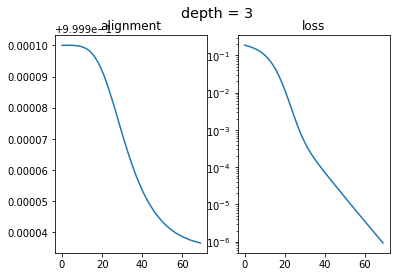

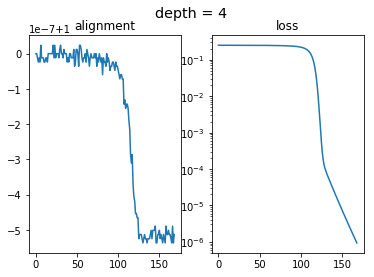

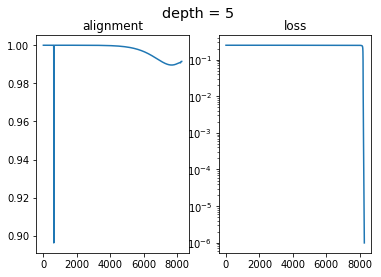

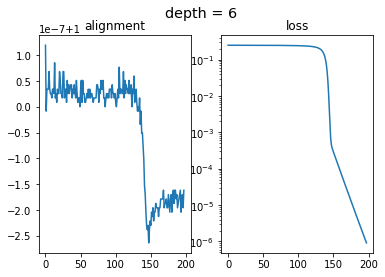

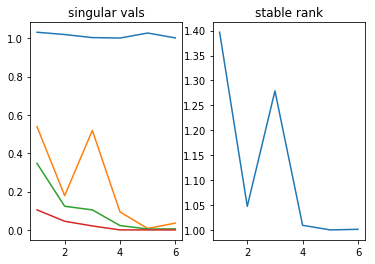

In [36]:
# initialize aligned
n = 4
all_losses = []
all_align = []
all_svals = []
for depth in range(1, 7):
    print("depth = " + str(depth))
    
    # initialize aligned
    init = 0.1*np.random.normal(size = (n, n))
    init = 0.5*init + 0.5*np.transpose(init)
    init[0][1] = 0
    init[1][0] = 0
    diag = 0.1*np.random.normal(size = (n-1))
    net = DeepZeroTrace(n, depth, init_vec = init, diag_vec=diag)

    # choose aligned x
    layer = net.layers[0].weight_matrix().detach().numpy()
    x = torch.tensor(np.linalg.svd(layer)[2][0].reshape(1, n))
    
    losses, align, svals = train.train(net, x, 1e-6)
    all_losses.append(losses)
    all_align.append(align)
    all_svals.append(svals[-1])
gen_plots(all_align, all_losses, all_svals)

In [37]:
np.trace(net.layers[0].weight_matrix().detach().numpy())

5.9604645e-08